In [10]:
'''
Students
David Castrejon: davidcastrejon@csus.edu
Blake Danz: blakedanz@csus.edu
Malkylm Wright: malkylmwright@csus.edu

Class
CSC180 - Yelp Assignment
'''

import os
import json

# Define the path to the JSON file
business_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/yelp_dataset/yelp_academic_dataset_business.json'
review_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/yelp_dataset/yelp_academic_dataset_review.json'
# checkin_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/yelp_dataset/yelp_academic_dataset_checkin.json'
# tip_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/yelp_dataset/yelp_academic_dataset_tip.json'
# user_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/yelp_dataset/yelp_academic_dataset_user.json'

paths = [review_path]

# Open the file and read it line by line
data = []
with open(business_path, 'r') as f:
    for line in f:
        # Parse each JSON object and append it to the data list
        entry = json.loads(line)
        data.append(entry)
print(f'Length of unfiltered business data: {len(data)} lines')

# Define a function to filter entries with less than 20 total reviews
def filter_reviews(entry):
    return entry['review_count'] >= 20

# Filter the entries
filtered_data = list(filter(filter_reviews, data))

# Specify the path for the new JSON file
output_file = 'filtered_yelp_academic_dataset_business.json'

# Save the new dataset to a JSON file
with open(output_file, 'w') as f:
    json.dump(filtered_data, f, indent=4)

# Read the entire file and parse it as a JSON array
with open(output_file, 'r') as f:
    data = json.load(f)

# Extract business IDs from the filtered data
filtered_business_ids = [entry['business_id'] for entry in data]
print(f'Number of business id\'s in filtered business data: {len(data)} lines')

# Define a function to filter entries based on business IDs
def filter_entries(entry):
    return entry['business_id'] in filtered_business_ids

# Iterate through each path
for path in paths:
    # Define the output file name for the filtered data
    output_file = f'filtered_{os.path.basename(path)[:-5]}.json'

    # Open the file and read it line by line
    filtered_data = []
    with open(path, 'r') as f:
        for line in f:
            # Parse each JSON object and filter entries based on business IDs
            entry = json.loads(line)
            if filter_entries(entry):
                filtered_data.append(entry)

    # Save the filtered dataset to a JSON file
    with open(output_file, 'w') as f:
        json.dump(filtered_data, f, indent=4)
    print(f'Length of filtered review data: {len(filtered_data)} lines')
    print(f'Processed {path}')
print('Finished filtering for businesses with >= 20 reviews!')

Length of unfiltered business data: 150346 lines
Number of business id's in filtered business data: 61919 lines
Length of filtered review data: 6114269 lines
Processed /Users/davidcastrejon/Documents/CSC180/hw/yelp/yelp_dataset/yelp_academic_dataset_review.json
Finished filtering for businesses with >= 20 reviews!


In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filtered_review_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/filtered_yelp_academic_dataset_review.json'

# Load data from the reviews JSON file
print("Loading data...")
with open(filtered_review_path, 'r') as f:
    reviews_data = json.load(f)
    
# Extract text reviews and star ratings
print("Extracting text reviews and star ratings...")
texts = [review['text'] for review in reviews_data]
stars = [review['stars'] for review in reviews_data]

# TF-IDF Vectorization
print("Performing TF-IDF Vectorization...")
vectorizer = TfidfVectorizer(min_df=0.008, max_df=0.1)  
X = vectorizer.fit_transform(texts).toarray()
print("Finished TF-IDF Vectorization!")

Loading data...
Extracting text reviews and star ratings...
Performing TF-IDF Vectorization...
Finished TF-IDF Vectorization!


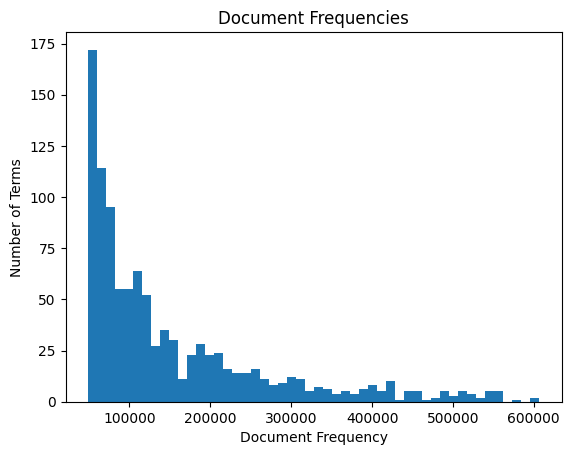

In [24]:
# Calculate document frequencies
doc_freq = np.sum(X > 0, axis=0)

# Plot histogram of document frequencies
plt.hist(doc_freq, bins=50)
plt.title('Document Frequencies')
plt.xlabel('Document Frequency')
plt.ylabel('Number of Terms')
plt.show()

In [25]:
# Print terms with extreme document frequencies
terms = vectorizer.get_feature_names_out()
print('Nuber of features:', len(terms), '\n')
threshold = 400000
print("Terms with high document frequency:")
print([terms[i] for i in np.where(doc_freq > threshold)[0]])
print('-' * 120)
threshold = 90000
print("Terms with low document frequency:")
print([terms[i] for i in np.where(doc_freq < threshold)[0]])

Nuber of features: 1025 

Terms with high document frequency:
['am', 'another', 'any', 'area', 'around', 'bar', 'before', 'being', 'better', 'both', 'cheese', 'chicken', 'day', 'dinner', 'down', 'drinks', 'eat', 'ever', 'every', 'everything', 'excellent', 'favorite', 'few', 'fresh', 'give', 'going', 'her', 'how', 'know', 'll', 'lunch', 'many', 'meal', 'minutes', 'most', 'new', 'next', 'night', 'now', 'off', 'pretty', 're', 'right', 'said', 'sauce', 'say', 'see', 'since', 'small', 'something', 'still', 'sure', 'table', 'take', 'then', 'think', 'times', 'took', 'two', 'wait', 'want', 'wasn', 'way', 'while', 'who']
------------------------------------------------------------------------------------------------------------------------
Terms with low document frequency:
['00', '100', '11', '25', '40', '45', 'above', 'accommodating', 'addition', 'affordable', 'afternoon', 'ahead', 'air', 'alone', 'american', 'anyway', 'anywhere', 'apparently', 'appointment', 'appreciate', 'aren', 'asking', '

In [26]:
# Splitting the data into train and test sets
print("Splitting the data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, stars, test_size=0.2, random_state=42)

print("Building the Sequential model...")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)                      # Output layer                        
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=1, restore_best_weights=True)
checkpoint_path = "model_checkpoint.keras"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Convert NumPy arrays to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Train the model with early stopping and model checkpointing callbacks
print("Training the model with early stopping and model checkpointing...")
history = model.fit(X_train_tf, y_train_tf, epochs=10, batch_size=32,
                    callbacks=[early_stopping, model_checkpoint], verbose=1)

Splitting the data into train and test sets...
Building the Sequential model...


/Users/davidcastrejon/Documents/CSC180/HW/yelp/yelp_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model with early stopping and model checkpointing...
Epoch 1/10
152837/152857 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8917
Epoch 1: loss improved from inf to 0.77188, saving model to model_checkpoint.keras
152857/152857 ━━━━━━━━━━━━━━━━━━━━ 207s 1ms/step - loss: 0.8916
Epoch 2/10
152832/152857 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7143
Epoch 2: loss improved from 0.77188 to 0.71407, saving model to model_checkpoint.keras
152857/152857 ━━━━━━━━━━━━━━━━━━━━ 201s 1ms/step - loss: 0.7143
Epoch 3/10
152823/152857 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7042
Epoch 3: loss improved from 0.71407 to 0.70594, saving model to model_checkpoint.keras
152857/152857 ━━━━━━━━━━━━━━━━━━━━ 200s 1ms/step - loss: 0.7042
Epoch 4/10
152819/152857 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6986
Epoch 4: loss improved from 0.70594 to 0.70106, saving model to model_checkpoint.keras
152857/152857 ━━━━━━━━━━━━━━━━━━━━ 195s 1ms/step - loss: 0.6986
Epoch 5/10
152849/152857 ━━━━━━━━━━━━━━━━━

In [27]:
# Load weights from best model
model.load_weights('model_checkpoint.keras')

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

# Convert NumPy arrays to TensorFlow tensors
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Evaluate the model
print("Evaluating the model...")
mse = model.evaluate(X_test_tf, y_test_tf, verbose=1)
print("Mean Squared Error:", mse)

# Predict star ratings for test data
print("Predicting star ratings for test data...")
predictions = model.predict(X_test_tf)  # Obtain predictions

# Calculate regression metrics
mae = mean_absolute_error(y_test_tf, predictions)
mse = mean_squared_error(y_test_tf, predictions)
rmse = mean_squared_error(y_test_tf, predictions, squared=False)  # Compute RMSE from MSE
r2 = r2_score(y_test_tf, predictions)

# Print regression report
print("Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Select random examples from the test set
num_examples = 5
random_indices = random.sample(range(len(X_test)), num_examples)

print(' ')

# Iterate over selected examples
for i in random_indices:
    # Get the text review, actual rating, and predicted rating for the i-th example
    review_text = texts[i]
    actual_rating = y_test[i]
    predicted_rating = predictions[i][0]
    
    # Print the review text, actual rating, and predicted rating
    print("Review Text:")
    print(review_text)
    print(f"Actual Rating: {actual_rating}")
    print(f"Predicted Rating: {predicted_rating:.2f}\n")


Evaluating the model...
38215/38215 ━━━━━━━━━━━━━━━━━━━━ 12s 317us/step - loss: 0.6215
Mean Squared Error: 0.6221225261688232
Predicting star ratings for test data...
38215/38215 ━━━━━━━━━━━━━━━━━━━━ 15s 393us/step
Regression Report:
Mean Absolute Error (MAE): 0.58
Mean Squared Error (MSE): 0.62
Root Mean Squared Error (RMSE): 0.79
R-squared (R2): 0.70
 
Review Text:
It's White Castle, anyone who knows me know's i have a strange fetish with this place. and this location feels like any other White Castle i've been too. Quick and good service, decently clean location and just a couple blocks down from the convention center!
Actual Rating: 5.0
Predicted Rating: 4.71

Review Text:
Even the best restaurants would do well to listen to their steady customers. And that's why I'm writing this. There is a problem with the pricing of Chef Ma's otherwise great hot and sour soup. The market price for hot and sour soup for two is three-four dollars. At Chef Ma's, it's $5.50. Yes there's enough soup 

/Users/davidcastrejon/Documents/CSC180/HW/yelp/yelp_venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
